# Chapter 8 - Tree-based Methods

- Decision tree 기법은 non-parametric supervised learning method (파라미터의 개수가 정해진 것이 아니라 데이터의 수에 따라 달라지는 것)
- 데이터 특징으로부터 추론된 간단한 규칙을 학습하여 목표변수의 값을 예측
- regression problems에 적용할 수도 있고, classification problem에 적용할 수 있는데, 순서대로 살펴볼 예정
- decision tree의 여러 단점들 (overfitting, unstable)을 극복할 수 있는 기법인 pruning, bagging, boosting, random forest 등을 살펴볼 예정

In [160]:
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from tqdm import tqdm
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main'

## 1. Regression Trees

학습 목표: TODO
* 왜 regression trees를 써야하는지를 이해하기
  - 야구선수의 연봉을 그 선수의 정보 (major league에서 뛴 연수, 작년에 얼마나 많이 히트를 쳤는지...)를 가지고 decision tree로 예측하기
  - 연봉 = continuous => regression tree (DecisionTreeRegressor)

### 1.1. Analyze & Prepare Data

* 야구선수들에 대한 정보가 담겨 있는 데이터셋
* shape: (263, 20), 즉 263명의 선수에 대한 feature (정보)가 들어있으며, feature는 20개임:
  - years: 선수가 major league에서 뛴 연수
  - hits: 선수가 지난 해에 친 hit의 개수
  - salary: 선수의 연봉

In [ ]:
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna() # missing values가 있는 row는 다 지우기
df.head(3)
df.shape

(263, 20)

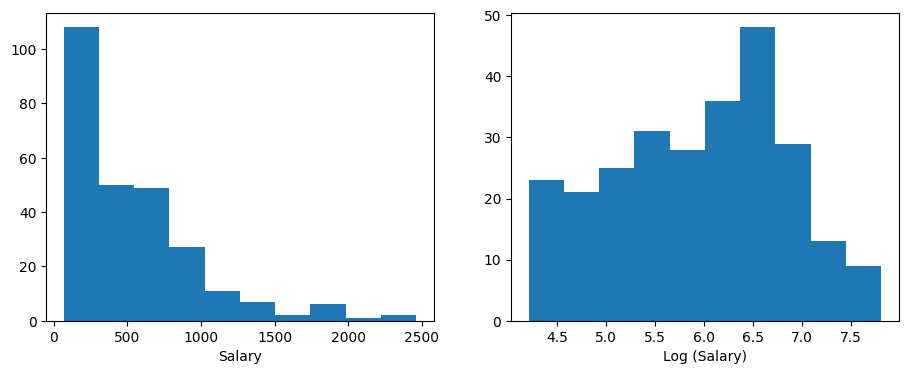

In [ ]:
# Prepare X, Y
X = df[['Years', 'Hits']]
Y = np.log(df['Salary'])

fig, axes = plt.subplots(1, 2, figsize=(11,4))
axes[0].hist(df['Salary'])
axes[1].hist(Y)

axes[0].set_xlabel('Salary')
axes[1].set_xlabel('Log (Salary)')
plt.show()

- Salary는 왼쪽으로 편향되어 있음.
- Log(Salary)는 대칭적이며, 정규화된 된 것으로 보임. 즉, Salary를 로그 변환을 해서 데이터의 왜도 (skewness)를 감소 시킴.

- 왜 중요한가? 보통 정규성을 가정하는 통계 기법이 더 많아서 이런 식으로 변환을 사용해서 데이터를 정규화해주면 더 많은 통계 기법을 사용할 수 있음. 또한 보통의 통계 기법이 정규 분포에서 결과가 가장 안정적으로 잘 나오기 때문에 정규화를 많이 함.
  - decision tree의 경우 그래도 다른 통계 기법과 다르게 데이터에 대한 가정을 하지 않기 때문에 더 robust.
  - target variable이 skewed되어 있으면 decision tree가 majority에 대해서만 더 잘 해주게 되어서 generalize하기가 어려움.



### 1.2. Train Regression Tree

Tree building process:
- Top-down, greedy approach.
  - Top-down: 가장 위에서 시작해서 predictor space를 연속적으로 계속 나눔.
  - Greedy: Tree를 만들 때 각각의 스텝에서, 전체 tree의 성능이 가장 좋아질 split을 하는 것이 아니라, 그 스텝에서만 봤을 때 할 수 있는 가장 좋은 split을 함.
- Process:

```
Terminating condition이 만족이 될 때까지:
  RSS가 가장 작아지는 predictor Xj와 threshold s를 찾음
```
---

DecisionTreeRegressor ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html))

* criterion: split의 quality를 계산해주는 방법. (어떤 predictor를 가지고 splitting할지, 어떤 threshold로 splitting할지 결정해주는 기준을 어떻게 계산할지)
  * squared_error (RSS), absolute_error, ...
* splitter: 각 노드에서 split을 어떻게 고를지.
  * best: 우리가 아는 Regression Tree 기법. 가장 낮은 criterion을 주는 feature/threshold를 고름.
  * random: features, threshold를 random하게 고름
* parameters about termination conditions (dealt more in 1.4)
  * max_leaf_nodes: tree가 가질 수 있는 최대 leaf node 개수. tree가 계속 split될 때, leaf node의 개수가 max_leaf_nodes를 도달할 때 멈춤


In [ ]:
regr = DecisionTreeRegressor(
    max_leaf_nodes=3,
    criterion='squared_error'
    )
regr.fit(X, Y)

DecisionTreeRegressor(max_leaf_nodes=3)

### 1.3. Plot Tree

* tree 시각화 하는 가장 간단한 방법: sklearn.tree의 plot_tree 함수 사용하기 ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html))
  * 다른 방법도 있음 (Supplementary)
* 그래프 설명 (요소 + tree 구현 방식)
* 중요 parameter
  * feature_names
  * max_depth
  * impurity
  * filled
  * proportion
  * node_ids

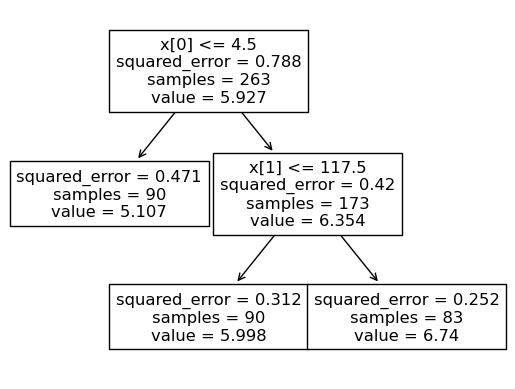

In [ ]:
_ = plot_tree(
    regr,
    )

* Years <= 4.5 노드 기준 왼쪽은 <= 4.5, 오른쪽은 Years > 4.5.
* squared_error: criterion 계산 결과 (squared_error, absolute_error...)
* samples: 노드에 해당되는 샘플의 개수
* value: 노드에 해당되는 샘플의 평균 값. prediction하면 이 값이 예측값이 됨.

---

* Leaf nodes: 노드 1, 3, 4
* Internal nodes: node 0, 2

---

* Tree는 선수들을 3부류로 묶음: 4.5년 이하로 활동한 선수들, 그 이상 활동했지만 히트를 117.5개 이하로 친 선수들, 그리고 그 이상을 친 선수들
* Years가 루트 노드에 가 있는 것을 보면 연봉을 정할 때 Hits보다 더 중요하게 보는 피처임. 다만 어느 정도 이상 major league에서 뛴 이상 Hits가 높아야지 고연봉자가 됨.

---

* 지금까지는 training set을 기반으로 트리를 만들었음.
* 그렇다면 실제 예측은 어떻게 하는가?
  * input data의 feature의 값을 가지고 leaf node까지 타고 내려오면 해당 leaf node가 갖는 training observations의 평균 값을 부여 (value값을 부여)
  * 함수: predict

In [ ]:
print(X.head(1))
print(regr.predict(X.head(1)))

print()

test_observation = [[10, 120]]
test_observation = pd.DataFrame([[10, 120]], columns=['Years', 'Hits'])
print(test_observation)
print(regr.predict(test_observation))

             Years  Hits
-Alan Ashby     14    81
[5.99837985]

   Years  Hits
0     10   120
[6.73968692]


### 1.4. Termination conditions

* scikit-learn에서 제공해주는 몇 가지 Terminating Conditions를 알아보기.
  * 위에서 max_leaf_nodes 이미 다룸
* Terminating conditions가 더 잘 보일 더 복작한 트리를 만들기 위해 모든 feature 다 쓰기
  * Class values (string)은 숫자로 만들어줘야함

In [36]:
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna() # missing values가 있는 row는 다 지우기
df.head(3)

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby      315    81      7    24   38     39     14    3449    835   
-Alvin Davis     479   130     18    66   72     76      3    1624    457   
-Andre Dawson    496   141     20    65   78     37     11    5628   1575   

               CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  \
-Alan Ashby        69    321   414     375      N        W      632       43   
-Alvin Davis       63    224   266     263      A        W      880       82   
-Andre Dawson     225    828   838     354      N        E      200       11   

               Errors  Salary NewLeague  
-Alan Ashby        10   475.0         N  
-Alvin Davis       14   480.0         A  
-Andre Dawson       3   500.0         N

In [37]:
# 이거 안 해주면 fit할 때 error 남
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], drop_first=True)

X = df.drop(columns=['Salary'])
Y = df['Salary']
X.head(3)

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby      315    81      7    24   38     39     14    3449    835   
-Alvin Davis     479   130     18    66   72     76      3    1624    457   
-Andre Dawson    496   141     20    65   78     37     11    5628   1575   

               CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  \
-Alan Ashby        69    321   414     375      632       43      10   
-Alvin Davis       63    224   266     263      880       82      14   
-Andre Dawson     225    828   838     354      200       11       3   

               League_N  Division_W  NewLeague_N  
-Alan Ashby           1           1            1  
-Alvin Davis          0           1            0  
-Andre Dawson         1           0            1

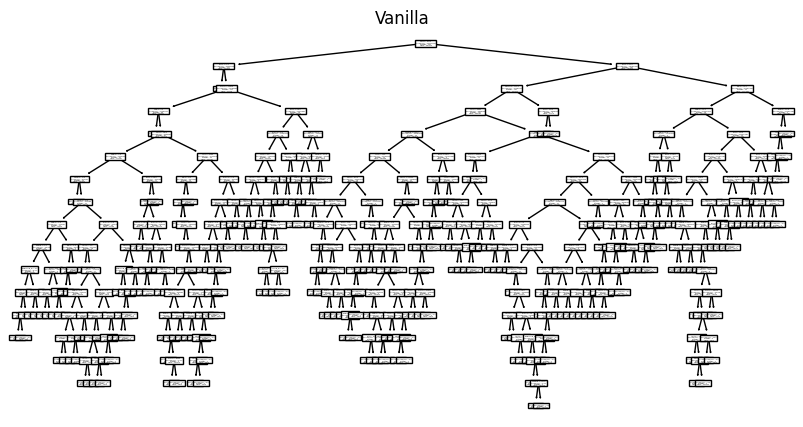

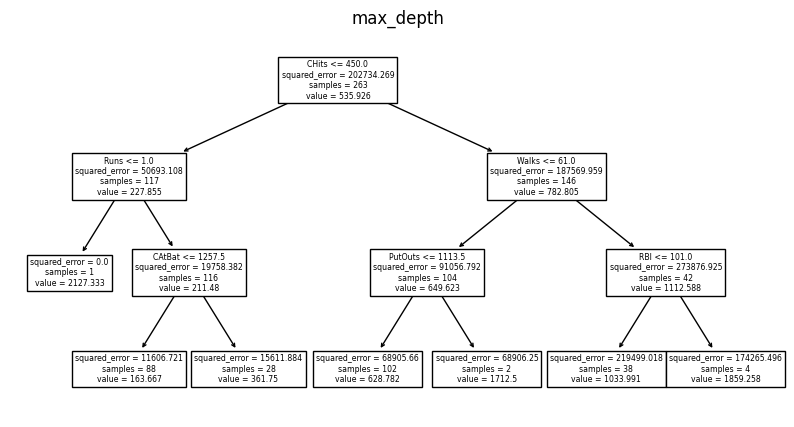

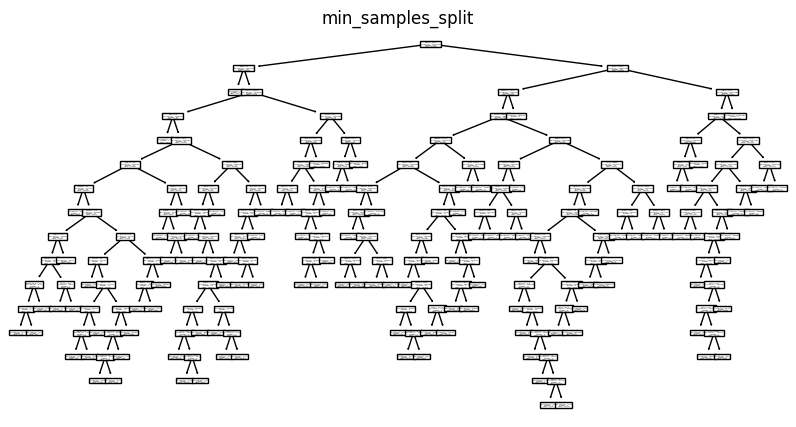

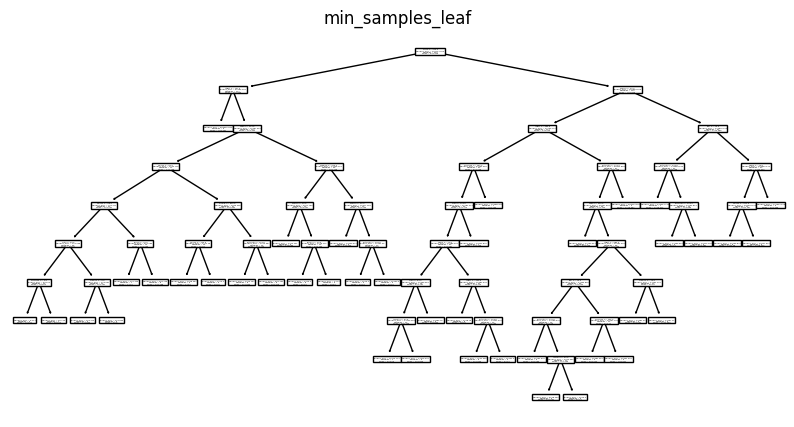

In [ ]:
# 아무것도 안 넣으면
regr = DecisionTreeRegressor()
regr.fit(X, Y)

fig, ax = plt.subplots(figsize=(10, 5))
_ = plot_tree(regr,
              ax=ax,
              feature_names=X.columns
              )
ax.set_title('Vanilla')
plt.show()


# max_depth (tree의 최대 depth 크기)
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X, Y)

fig, ax = plt.subplots(figsize=(10, 5))
_ = plot_tree(regr,
              ax=ax,
              feature_names=X.columns
              )
ax.set_title('max_depth')
plt.show()


# min_samples_split (node를 split하기 위해 필요한 최소 샘플의 개수)
regr = DecisionTreeRegressor(min_samples_split=5)
regr.fit(X, Y)

fig, ax = plt.subplots(figsize=(10, 5))
_ = plot_tree(regr,
              ax=ax,
              feature_names=X.columns
              )
ax.set_title('min_samples_split')
plt.show()


# min_samples_leaf (Leaf node에 해당되어야하는 최소 샘플의 개수)
regr = DecisionTreeRegressor(min_samples_leaf=5)
regr.fit(X, Y)

fig, ax = plt.subplots(figsize=(10, 5))
_ = plot_tree(regr,
              ax=ax,
              feature_names=X.columns
              )
ax.set_title('min_samples_leaf')
plt.show()

Termination Condition을 어떻게 주는지에 따라서 tree의 complexity가 달라짐.

### 1.5. Exercise: exploring termination conditions

Using the reference below, try out different termination conditions. (5min)
- Ref: [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [ ]:
# Explore different termination conditions!

In [ ]:
# max_features (split할 때마다 후보로 고려하는 최대 feature의 개수) + random_state (feature를 고르기 전 shuffling 방법 지정)
# 나중에 bagging할 때 쓰일 예정 (매 tree마다 서로 다른 feature를 봐서, 서로 다른 트리를 많이 만듦 --> 평균 트리: 너무 강한 feature가 dominate하는 것 방지 --> 더 다양한 값에 대해 안정적으로 예측할 수 있음)
regr = DecisionTreeRegressor(max_features=3, random_state=1)
regr.fit(X, Y)

fig, ax = plt.subplots(figsize=(10, 5))
_ = plot_tree(regr,
              ax=ax,
              feature_names=X.columns
              )
ax.set_title('max_features, random_state')
plt.show()

### 1.6 Pruning

Decision Tree:
* 장점:
  - 시각화할 수 있고, 이해하고 해석하기 쉬움 (white-box: 어떤 경위로 해당 예측값에 도달했는지 이해 가능).
  - 데이터 처리할게 많지 않음.
  
* 단점:
  - 특정 클래스가 너무 많으면 biased될 수 있음. ==> dataset을 어느 정도 balance해야함
  - **Overfitting이 발생할 수 있음 (over-complex trees) ==> pruning을 통해서 어느 정도 해결**
  - Unstable. 데이터의 작은 변화로도 완전히 다른 트리가 만들어질 수 있음 ==> ??


Pruning algorithm 설명

* ccp_alpha: Minimal Cost-Complexity Pruning을 하기 위해 complexity를 조절해주는 값. CCP는 tree의 complexity와 training data에 대한 fit의 tradeoff를 alph라는 parameter를 통해 조절해주는 알고리즘.
  * alpha가 0이면, complexity에 대한 고려를 전혀 안 할 것이다라는 뜻이고, 이는 즉 training set error가 얼마나 작은지에만 신경쓰며 tree를 만들 것이다라는 뜻이다 (여태까지 한 것처럼).
  * alpha 값이 클수록 complexity에 대한 고려가 커져서 더 작은 tree를 만들게 된다는 뜻이다.


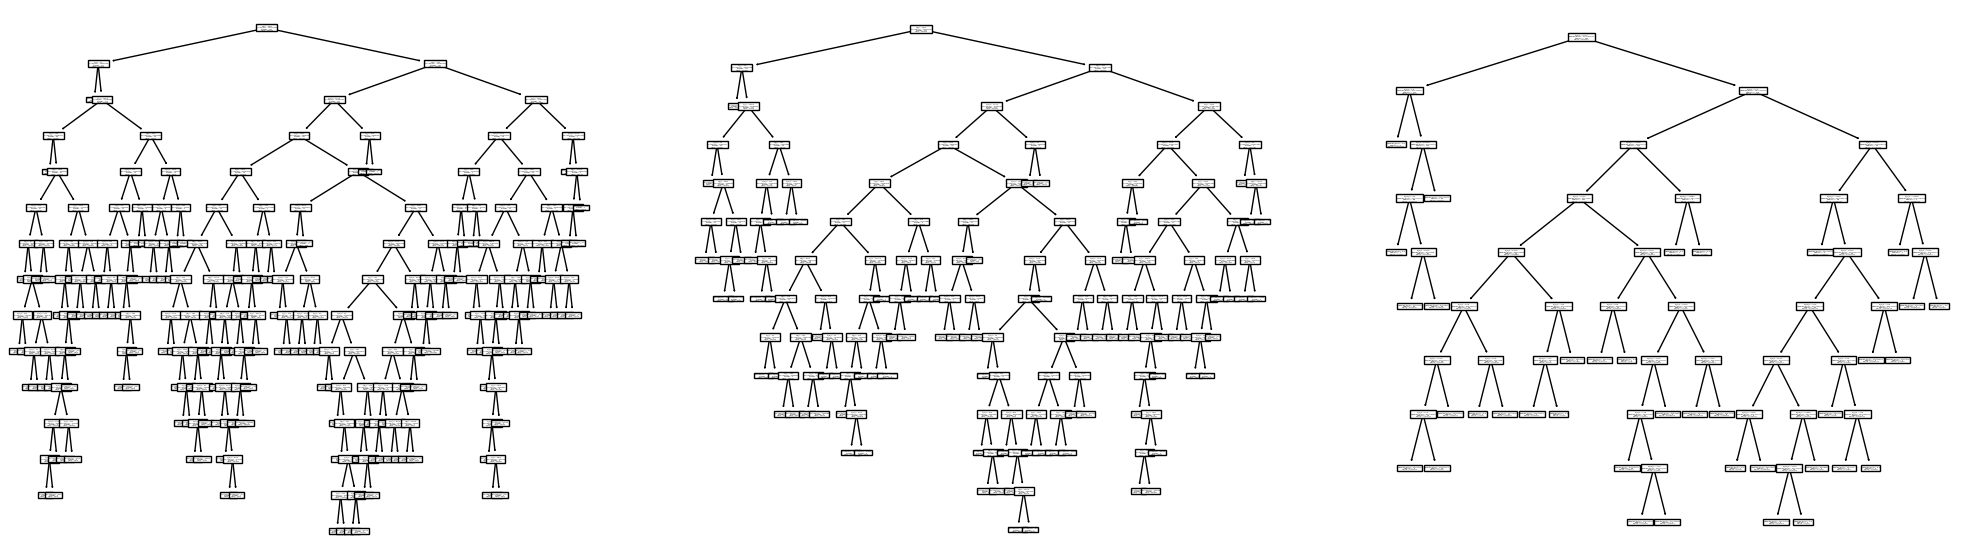

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
regrs = []
# Training (alpha=5)
regrs.append(DecisionTreeRegressor(ccp_alpha=5))
regrs[0].fit(X, Y)

# Training (alpha=50)
regrs.append(DecisionTreeRegressor(ccp_alpha=50))
regrs[1].fit(X, Y)


# Training (alpha=500)
regrs.append(DecisionTreeRegressor(ccp_alpha=500))
regrs[2].fit(X, Y)

_ = plot_tree(regrs[0], ax=axes[0])
_ = plot_tree(regrs[1], ax=axes[1])
_ = plot_tree(regrs[2], ax=axes[2])

alpha 값이 커지며 tree가 덜 complex해짐.

### 1.7. Exercise: finding best alpha using CV

이론에서 배운 것처럼, CCP는 보통 cross-validation을 통해서 최적의 alpha 값을 찾는 경우가 많음.

Write your code in the cells below. (15min)
1. Prepare train / test data
2. Calculate cross validation error with different $\alpha$. (Use Mean Square Error (MSE))
3. Calculate test error with different $\alpha$. (Use Mean Square Error (MSE))
4. Plot a Graph with the errors (X: $\alpha$, y: Test error, CV error) and get the proper $\alpha$ with CV error.
5. (Additional) Plot a vertical line indicating the best alpha found using cross-validation

**1.7.1. Prepare train / test data**

In [ ]:
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna() # missing values가 있는 row는 다 지우기
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], drop_first=True)

X = df.drop(columns=['Salary'])
Y = df['Salary']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(210, 2) (53, 2) (210,) (53,)


**1.7.2. Calculate cross validation error with different $\alpha$. (Use Mean Square Error (MSE))**

In [ ]:
ccp_alphas = np.exp([0.1*x for x in range(200)])

cv_errors = []











**1.7.3. Calculate test error with different $\alpha$. (Use Mean Square Error (MSE))**

In [ ]:
test_errors = []











**1.7.4. Plot a Graph with the errors (X: $\alpha$, y: Test error, CV error) and get the proper $\alpha$ with CV error.**

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.log(ccp_alphas), cv_errors, label='cv')
ax.plot(np.log(ccp_alphas), test_errors, label='test')

# Additional

ax.legend()
fig.show()

best ccp_alpha:  4023.872393822313 , and its corresponding cv error:  90128.89049939676
Obtained by best_params_:  {'ccp_alpha': 4023.872393822313}  ==  Obtained by indexing:  {'ccp_alpha': 4023.872393822313}
calculated y_max 345265.8170359464
axis y_max 358022.6633627739


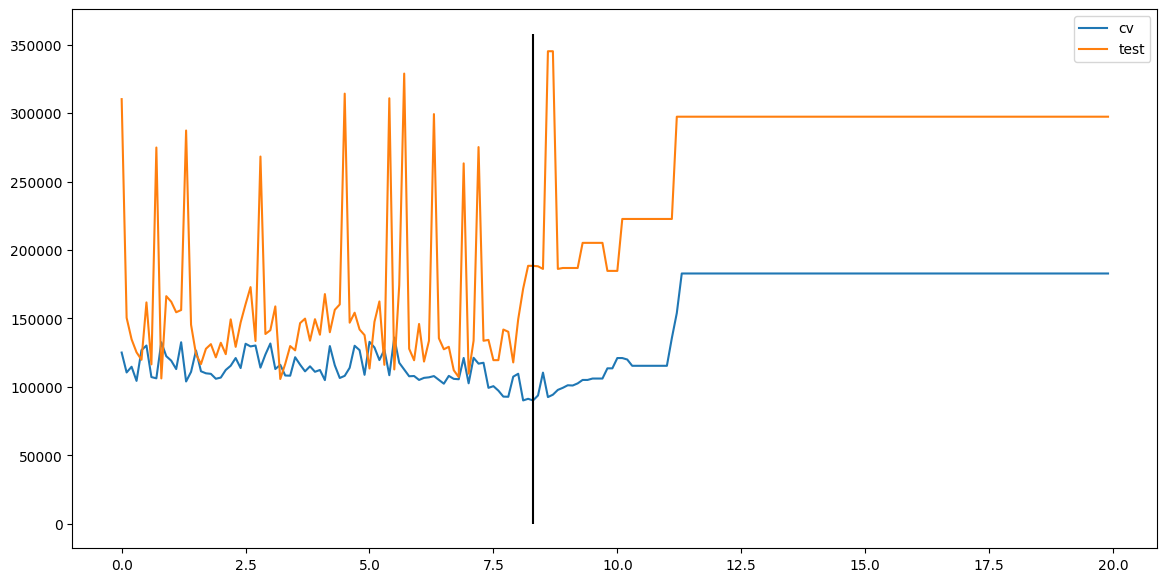

* Test error와 cv (training error)는 비슷한 양상을 띔. 즉, CV error는 test error에 대한 괜찮은 근사치이다.

* 초반에 어느정도 선까지는 ccp_alpha가 커지면서 cv/test error 모두 줄어든다. 즉, pruning을 통해서 overfitting을 어느 정도 막음.

* 너무 많이 pruning을 하게 되면 오히려 cv/test error가 증가한다. 트리가 너무 단순해져서 그런걸 수 있다.

## 2. Classification Trees

학습 목표:
TODO


* Classification tree는 방금 본 regression tree와 매우 비슷.
* 다른 점:
  * regression tree는 quantitative data를 예측하는거라면, classification은 qualitative (class) 데이터를 예측하는 것임.
  * regression tree의 예측된 값은 같은 region으로 분류된 training observations의 평균값. VS classification은 해당 region에서 가장 많이 관측된 class임.
  * criterion: RSS, absolute error... vs
    * GINI index (purity라고도 불림. 작으면 작을수록 하나의 노드가 하나의 클래스로 이뤄져있다는 뜻)
    * entropy/log loss (GINI와 비슷하게 작으면 작을수록 하나의 노드가 하나의 클래스로 이뤄져있음)
* 코딩은 매우 비슷.
  * 사용 예시: 환자의 건강에 대한 다양한 관측치를 가지고 심장병이 있는지 없는지 판단하기


### 2.1. Analyze & Prepare Data

Dataset: 가슴 통증을 느끼는 303명의 환자에 대한 데이터셋 (missing values 있는거 빼면 297명). 총 14개의 feature (정보)를 각 환자에 대해서 알려주며, 그 중 하나는 HD (heart disease) 심장병 유무를 알려줌.

In [30]:
df = pd.read_csv(f'{BASE_DIR}/Data/Heart.csv', index_col=0).dropna()
print(df.shape)
df.head(3)

(297, 14)


Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
1   63    1       typical     145   233    1        2    150      0      2.3   
2   67    1  asymptomatic     160   286    0        2    108      1      1.5   
3   67    1  asymptomatic     120   229    0        2    129      1      2.6   

   Slope   Ca        Thal  AHD  
1      3  0.0       fixed   No  
2      2  3.0      normal  Yes  
3      2  2.0  reversable  Yes

In [31]:
# Data => X, Y
X = df.drop(columns=['AHD', 'ChestPain', 'Thal'])  # discrete predictors는 일단 빼줌 (넣으려면 get_dummies 이용해서)
Y = df['AHD'].map({'Yes': 1, 'No': 0})
X.head(3)

Age  Sex  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  Slope   Ca
1   63    1     145   233    1        2    150      0      2.3      3  0.0
2   67    1     160   286    0        2    108      1      1.5      2  3.0
3   67    1     120   229    0        2    129      1      2.6      2  2.0

### 2.2. Train Classification Tree

In [27]:
clf = DecisionTreeClassifier(
    max_leaf_nodes=6,
    max_features=3, # 6
    # max_depth=4
    )
clf.fit(X, Y)

DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

### 2.3. Plot Tree

   Age  Sex  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  Slope   Ca
1   63    1     145   233    1        2    150      0      2.3      3  0.0
2   67    1     160   286    0        2    108      1      1.5      2  3.0
[1 1]


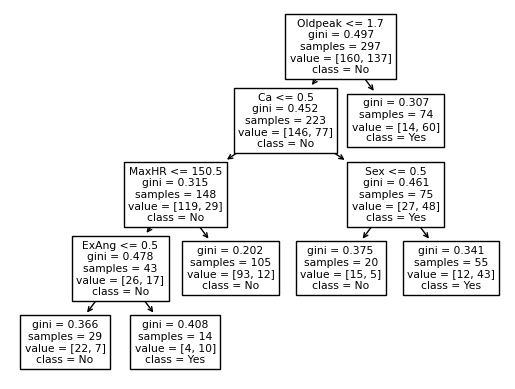

In [28]:
# fig, ax = plt.subplots(figsize=(20, 15))
_ = plot_tree(clf,
              feature_names=X.columns,
              class_names=['No', 'Yes'],   # target class 이름 지정해주기 (오름차순) ([0 (No), 1 (Yes)] NOT [1 (Yes), 0 (No)])
              # ax=ax
              )
print(X.head(2))
print(clf.predict(X.head(2)))

### 2.4. Analyze the Result

* 가장 중유한 피처는 'Slope', 'Sex', 'Age', 'Oldpeak' 및 'Ca'라고 볼 수 있다.
* Try other values for parameters:
  * 일부 분할에서는 동일한 예측 값을 갖는 두 개의 최종 노드가 생성됨. 그렇다면 분할이 수행되는 이유는 무엇일까? 분할을 하면 노드 순도가 증가하기 때문에 수행됩니다. 노드 순도가 중요한 이유는 노드가 불순한지 여부는 훨씬 덜 확실합니다. 분류 오류를 줄이지 않고 노드 순도에 더 민감한 지니 지수와 엔트로피를 향상시킵니다.

In [29]:
clf.score(X, Y) # Mean accuracy

0.8181818181818182

## 3. Bagging and Random Forests

Decision Tree:
* 장점:
  - 시각화할 수 있고, 이해하고 해석하기 쉬움 (white-box: 어떤 경위로 해당 예측값에 도달했는지 이해 가능).
  - 데이터 처리할게 많지 않음.
  
* 단점:
  - 특정 클래스가 너무 많으면 biased될 수 있음. ==> dataset을 어느 정도 balance해야함
  - Overfitting이 발생할 수 있음 (over-complex trees) ==> pruning을 통해서 어느 정도 해결
  - **High Variance. 데이터의 작은 변화로도 완전히 다른 트리가 만들어질 수 있음 ==> Decision tree 여러개를 합쳐서 어느 정도 해결. 바로 다음에 살펴볼 bagging, random forest가 그 예시.**


![](https://aiml.com/wp-content/uploads/2023/03/Bagging-2.png)

![](https://miro.medium.com/v2/resize:fit:1358/1*i69vGs4AfhdhDUOlaPVLSA.png)

### 3.1. Analyze Data

Dataset Description: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html.

Boston Mass라는 지역의 주택에 관한 전반적인 정보를 담고 있는 데이터셋. 총 506개의 case에 대해 14개의 feature (정보)를 담고 있다.
  - medv: 수요자가 거주하는 주택의 중앙 값 ($1000 단위로 표현)
  - nox: 공기의 nitric oxide (산화질소) 농도
  - age: 1940년 이전에 건축된 주택의 비율

목표: 모든 정보를 이용해 집값 (medv)을 맞추기

In [79]:
df = pd.read_csv(f'{BASE_DIR}/Data/Boston.csv')
print(df.shape)
df.head(3)

(506, 14)


crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7

In [80]:
# Data => X, Y
X = df.drop(columns=['medv'])
Y = df.medv

# Split Train/Test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(253, 13) (253, 13) (253,) (253,)


### 3.2. Create Random Forest Regressors with Various Number of Features

Random Forest Regression:
* Observations 여러개를 평균내면 보통 variance가 줄어듬 ==> Tree 여러개를 합쳐서 generalization을 높이자!
* 비슷한 tree끼리 평균내면 쓸모가 없음... ==> tree끼리 서로 달라야함.
* Tree 생성할 때 Randomness를 도입해서 트리를 서로 다르게 만들자.
  * 각각의 tree가 predictors의 서로 다른 subset을 보게 하므로써 비교적 약한 predictor에 더 많은 기회를 제공할 수 있음

```
For each bootstrapped training samples:
  Build a decision tree, where:
    For each split, a new random subset of predictors are used instead of all the predictors
```


Bagging:
- Random Forest와 매우 유사, 다만 split할 때마다 모든 predictor를 다 고려함

Important Parameters:
* n_estimator: 식에서 B에 해당됨. 즉, bootstrapping을 몇 번할 것이냐 (몇 개의 tree를 만들어서 평균 낼 것이냐)
* max_features: split할 때마다 몇개의 feature만 고려할 것이냐 (for best split)
  * random_state: feature 고르기 전, bootstrapping하기 전 shuffling 방법

In [85]:
# Using all features (== Bagging)
regr_all = RandomForestRegressor(max_features=13, random_state=1)  # max_features: default 1.0
# Using half features
regr_half = RandomForestRegressor(max_features=6, random_state=1)
# Using sqrt(p) features
regr_sqrt = RandomForestRegressor(max_features=4, random_state=1)
# Using plain DecisionTreeRegressor
regr_tree = DecisionTreeRegressor(max_features=13, random_state=1)

regr_all.fit(X_train, Y_train)
regr_half.fit(X_train, Y_train)
regr_sqrt.fit(X_train, Y_train)
regr_tree.fit(X_train, Y_train)

DecisionTreeRegressor(max_features=13, random_state=1)

### 3.3. Train and Evaluate the Regressors

In [88]:
print('regr_all ', regr_all.score(X_test, Y_test))
print('regr_half', regr_half.score(X_test, Y_test))
print('regr_sqrt', regr_sqrt.score(X_test, Y_test))
print('regr_tree', regr_tree.score(X_test, Y_test))

regr_all  0.7866506352833871
regr_half 0.7912885991135217
regr_sqrt 0.7835452510596893
regr_tree 0.6860783362322995


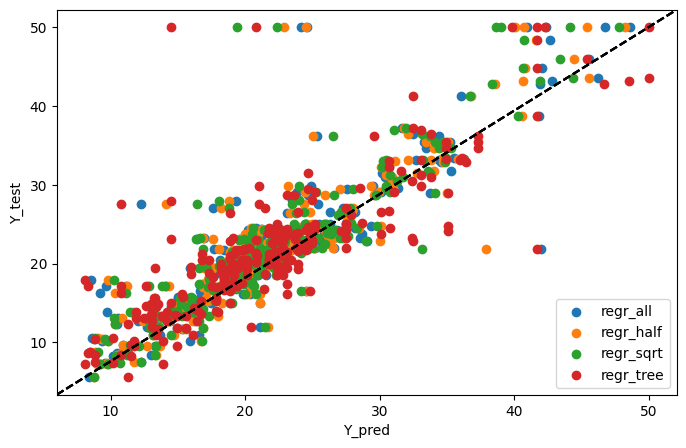

In [92]:
# Compare results
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['regr_all', 'regr_half', 'regr_sqrt', 'regr_tree']
MSEs = []
for label, regr in zip(labels, [regr_all, regr_half, regr_sqrt, regr_tree]):
    Y_pred = regr.predict(X_test)
    MSE = mean_squared_error(Y_test, Y_pred)
    MSEs.append(MSE)

    ax.scatter(Y_pred, Y_test, label=label)
    ax.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)  # transform: specify the coordinate system that the drawing should use.
                                                                   # In this case, use axis coordinates: bottom-left (0, 0), top-right (1, 1).
    ax.set_xlabel('Y_pred')
    ax.set_ylabel('Y_test')
ax.legend()
plt.show()

* 너무 겹침 --> alpha

* 예측값이 검은선에 가까우면 가까울수록 완벽함. 더 퍼져있으면 있을 수록 안 좋음.
* 대체적으로 feature를 적게 보든, 많이 보든 크게 다른 것 없이 잘 예측함. 다만 약간의 variance는 조금 있음.

[16.17512869960475, 15.82350045849802, 16.41056408300395, 23.800039525691698]


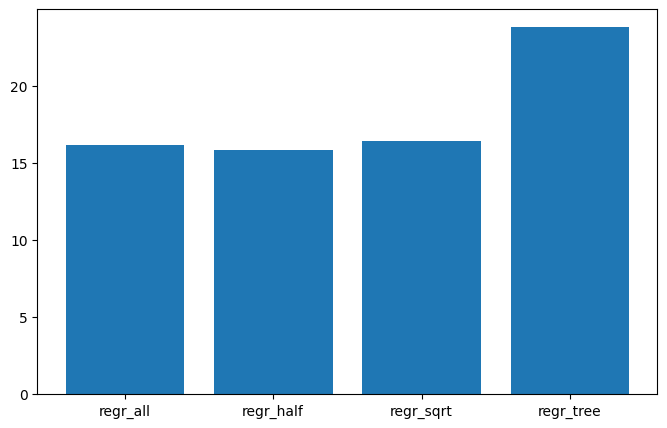

In [93]:
# Mean Square Errors
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, MSEs)
print(MSEs)
plt.show()

### 3.4. Plot Feature Importances

Ensemble 장점:
* 예측 결과 성능 향상

Ensemble 단점:
* Interpretability가 떨어짐 (어떻게 분류되는지 시각화할 수도 없고, 더 이상 어떤 feature가 분류 과정에 가장 중요한지 모름)

그나마 각 feature의 중요성에 대한 전반적 요약을 **feature_importances**를 통해 볼 수 있음.

feature_importances = 해당 feature로 인해 criterion이 얼마나 줄어들었는지 (정규화된 총 합 값). GINI importance라고도 불림. 총 합은 1.0 (즉 비율을 나타내줌)

In [94]:
np.sum(regr_all.feature_importances_)

1.0

In [95]:
for feat_name, importance in zip(regr_all.feature_names_in_, regr_all.feature_importances_):
  print(feat_name, importance)

print()

for feat_name, importance in zip(X.columns, regr_all.feature_importances_):
  print(feat_name, importance)

crim 0.03528629305325273
zn 0.001143555265942954
indus 0.007941985408789787
chas 0.0010160247410443384
nox 0.010753315918520698
rm 0.32944791371587717
age 0.01643056608814391
dis 0.04369568598818205
rad 0.004434211657453525
tax 0.012973687762245199
ptratio 0.02197933715933444
black 0.011278160580601554
lstat 0.5036192626606116

crim 0.03528629305325273
zn 0.001143555265942954
indus 0.007941985408789787
chas 0.0010160247410443384
nox 0.010753315918520698
rm 0.32944791371587717
age 0.01643056608814391
dis 0.04369568598818205
rad 0.004434211657453525
tax 0.012973687762245199
ptratio 0.02197933715933444
black 0.011278160580601554
lstat 0.5036192626606116


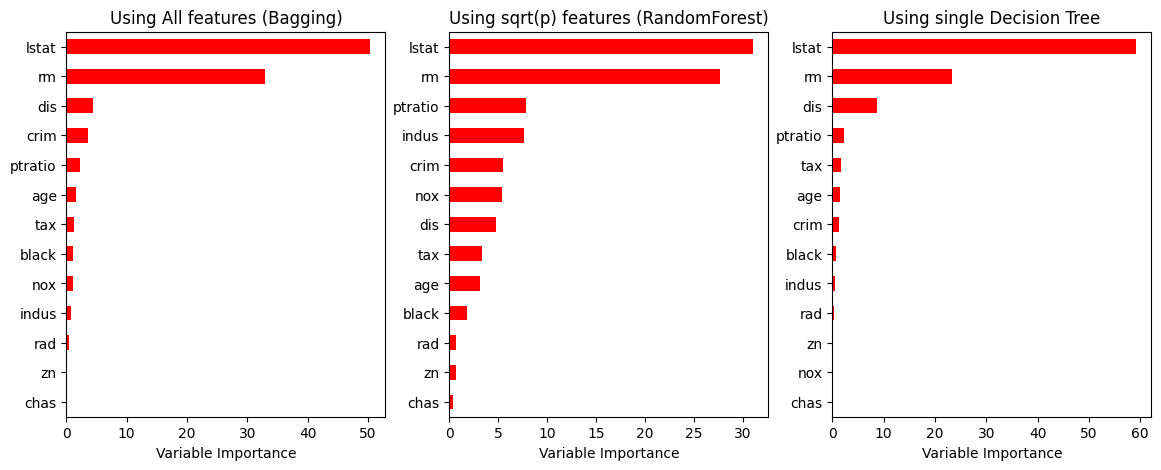

In [97]:
## Feature Importance
# Using all features
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

importance_all = pd.DataFrame({'Importance': regr_all.feature_importances_*100}, index=X.columns)
importance_sqrt = pd.DataFrame({'Importance': regr_sqrt.feature_importances_*100}, index=X.columns)
importance_tree = pd.DataFrame({'Importance': regr_tree.feature_importances_*100}, index=X.columns)

importance_all.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', ax=axes[0])  # pandas로 바로 plot (horizontal bar)
importance_sqrt.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', ax=axes[1])
importance_tree.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', ax=axes[2])

axes[0].set_title('Using All features (Bagging)')
axes[1].set_title('Using sqrt(p) features (RandomForest)')
axes[2].set_title('Using single Decision Tree')

axes[0].set_xlabel('Variable Importance')
axes[1].set_xlabel('Variable Importance')
axes[2].set_xlabel('Variable Importance')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()

plt.show()

* lstat, rm이 가장 중요
* 왼쪽 (bagging)은 lstat가 거의 0.5%의 비중으로 tree가 구성된다면, Random Forest는 random성이 더 추가가 되어 (split할 때 feature를 다 보지 않고 일부만 random하게 봄), importance가 더 분산됨 (**set_xlim 추가하기**)
  * ==> random forest는 random성을 가장 많이 추가해 특정 하나의 feature의 영향을 줄이게 됨.
  * ==> overfitting을 줄이고, generalize를 더 잘 할 수 있음.


* feature importance를 왜 봐야하느냐?
  * For interpretability.
  * 그럼 해석하는것이 왜 중요한가?
    * 데이터셋에 어떤 데이터를 더 많이 collect해야하는지, 어떤 feature를 더 많이 넣어야하는지 (computation cost 때문에 최소로 한다면)

### 3.5 Exercise: Feature Importance
Write your code in the cells below. (10min)<br/>
Use *Hitters* dataset<br/>
Predict `Salary` using other features.
1. Load data
2. Preprocess data
3. Split train / test data
4. Train random forest regressor with train data
5. Compare feature importances

**3.5.1. Load data**

In [98]:
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna()
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], drop_first=True)
df.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  \
-Alan Ashby            69    321   414     375      632       43      10   
-Alvin Davis           63    224   266     263      880       82      14   
-Andre Dawson         225    828   838     354      200       11       3   
-Andres Galarraga      12     48    46      33      805       40       4   
-Alfredo Griffin       19    501   336     194      282      421      25   

                   Salary  League_N  Division_W  NewLeague_N  
-Alan Ashby         475.0         1           1            1  
-Alvin Davis        480.0         0           1            0  
-Andre Dawson       500.0         1           0            1  
-Andres Galarraga    91.5         1           0            1  
-Alfredo Griffin    750.0         0           1            0

**3.5.2. Preprocess data**

In [99]:
X = df.drop(columns=['Salary']).dropna()
Y = df['Salary']
print(X.shape, Y.shape)

(263, 19) (263,)


**3.5.3. Split train / test data**

**3.5.4. Train random forest regressor with train data**

**3.5.5. Compare feature importances**

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))


# Fill here


ax.set_title('Train')
ax.set_xlabel('Variable Importance')
ax.get_legend().remove()
plt.show()

## Boosting

![](https://miro.medium.com/v2/resize:fit:1153/1*XzaoQxMf4uLD5DIHz8JwbA.png)

* Tree가 서로 independent하게 grow VS Former tree affects latter tree (sequential growth)
* 예측값: 트리들의 평균 VS 트리의 합

### 4.1 Gradient Boosting

In [100]:
df = pd.read_csv(f'{BASE_DIR}/Data/Boston.csv')
df.head(3)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7

In [101]:
# Data => X, Y
X = df.drop(columns=['medv'])
Y = df['medv']

# Split Train/Test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(253, 13) (253, 13) (253,) (253,)


Scikit에서 Boosting 구현:
* GradientBoosting
* HistGradientBoosting

둘이 비슷한데, n_samples >= 10000이 되면 HistGradientBoosting이 몇 magnitude 빠름.


* Important parameters ([documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html))
  - n_estimators: 44쪽 식에서 B에 해당됨
  - learning_rate: 식에서 lambda에 해당됨
  - loss: residuals 어떻게 계산할지



In [106]:
regr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=1)
regr.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=1)

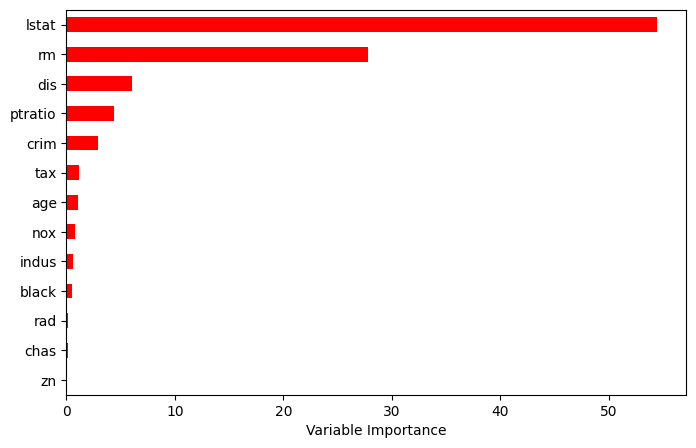

0.8023968989693497


In [107]:
# Feature Importances
fig, ax = plt.subplots(figsize=(8, 5))

importance = pd.Series(regr.feature_importances_*100, index=X.columns)
importance.sort_values(inplace=False).plot(kind='barh', color='r', ax=ax)

ax.set_xlabel('Variable Importance')
plt.show()

print(regr.score(X_test, Y_test))

### 4.2. Exercise: Compare train/test MSE to find B for Boosting
Write your code in the cells below. (10min)
1. Calculate train and test errors with various Number of Trees (B). (Use MSE)
2. Plot graph (X: number of trees, y: train error, test error)

In [ ]:
# Calculate train and test errors with various Number of Trees. (Use MSE)
n_estimators_list = [500*x for x in range(1, 21)]

train_errors, test_errors = [], []
for n_estimators in tqdm(n_estimators_list):
    pass










100%|██████████| 20/20 [01:38<00:00,  4.95s/it]


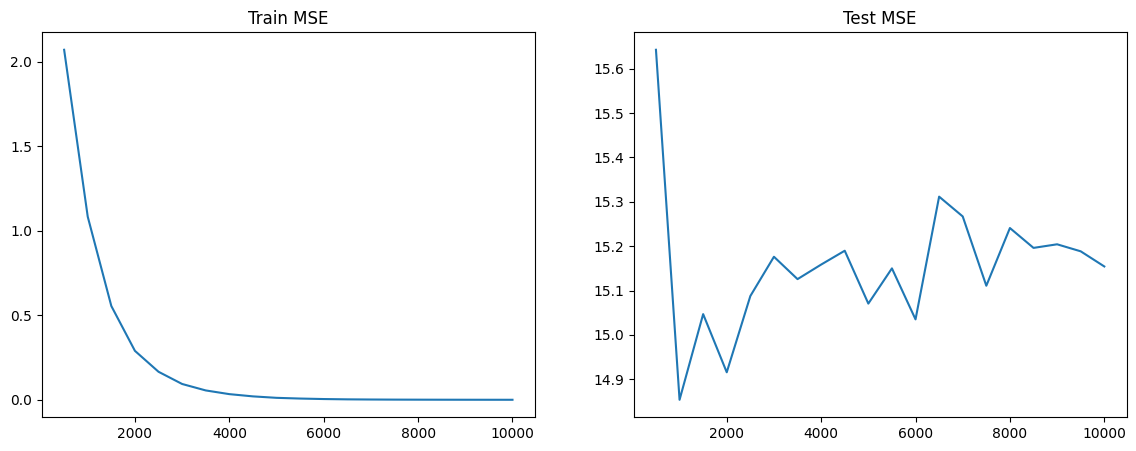

In [ ]:
# Plot graph (X: number of trees, y: train error, test error)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(n_estimators_list, train_errors)
axes[1].plot(n_estimators_list, test_errors)

axes[0].set_title('Train MSE')
axes[1].set_title('Test MSE')
fig.show()

* 왼쪽:
  - number of trees가 추가되면 될수록 에러가 확 줄어듬. 어느 순간부터는 (대략적으로 4500정도) 에러가 더 이상 줄어들지 않음. 즉, 4500 이상의 tree를 써도 MSE를 줄이는데에는 전혀 효과가 없음
  - 에러가 전반적으로 매우 작음. Overfitting이 된게 아닌가 의심스러움.

* 오른쪽:
  - tree의 개수를 늘리니 처음에는 확 에러가 줄어듬. 다만 어느 순간 (대략 1000)을 넘어가니 에러가 오히려 증가함.

* 대략 tree를 1000개 정도로 잡으면 됨. (해당되는 training 에러가 커보일 수 있지만 y가 같은 scale이 아님)

다른 Boosting 기법:
* AdaBoost: [tutorial](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

## 4. Bagging, Voting

### 5.1. BaggingRegressor

In [137]:
# Load data
df = pd.read_csv(f'{BASE_DIR}/Data/Boston.csv')

# Data => X, Y
X = df.drop(columns=['medv'])
Y = df['medv']

# Split Train/Test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [138]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((253, 13), (253, 13), (253,), (253,))

24.492608695652173 16.601541501976286


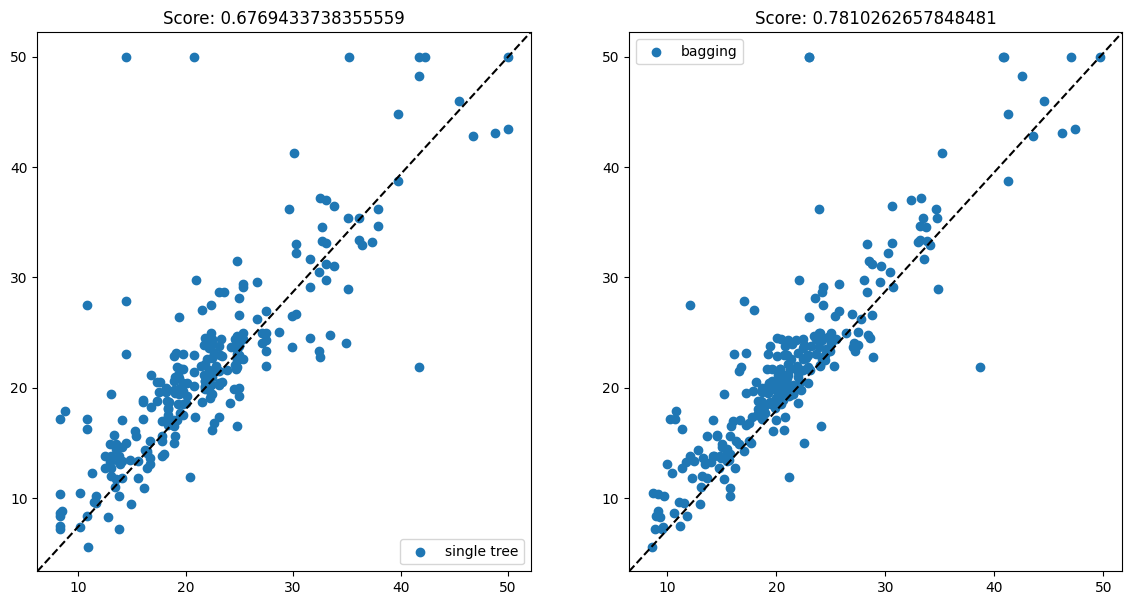

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))


regr = DecisionTreeRegressor()
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)

MSE_decision_tree = mean_squared_error(Y_test, Y_pred)
ax1.plot([0, 1], [0, 1], '--k', transform=ax1.transAxes)
ax1.scatter(Y_pred, Y_test, label='single tree')

ax1.set_title("Score: {}".format(regr.score(X_test, Y_test)))
ax1.legend()


regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)

MSE_bagging = mean_squared_error(Y_test, Y_pred)
ax2.scatter(Y_pred, Y_test, label='bagging')
ax2.plot([0, 1], [0, 1], '--k', transform=ax2.transAxes)
ax2.set_title("Score: {}".format(regr.score(X_test, Y_test)))
ax2.legend()

print(MSE_decision_tree, MSE_bagging)

### 5.2. BaggingClassifier

In [149]:
# Load data
df = pd.read_csv(f'{BASE_DIR}/Data/Carseats.csv', index_col=0)
df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'])
df.head(3)

Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
1   9.50        138      73           11         276    120   42         17   
2  11.22        111      48           16         260     83   65         10   
3  10.06        113      35           10         269     80   59         12   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
1              1               0                 0         0          1   
2              0               1                 0         0          1   
3              0               0                 1         0          1   

   US_No  US_Yes  
1      0       1  
2      0       1  
3      0       1

In [150]:
# Add High predictor
df['High'] = df['Sales'].map(lambda x: 1 if x>8 else 0)

# Data => X, Y
X = df.drop(['Sales', 'High'], axis=1)
Y = df['High']

# Split train/test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(200, 14) (200, 14) (200,) (200,)


In [151]:
# Ref https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(
        y_true,
        y_pred,
        labels=None,
        target_names=None,
        normalize=False,
        cmap=plt.get_cmap('Blues'),
        title='Confusion matrix',
        figsize=(8, 6)):
    '''
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    y_true:       1d array-like
                  Ground truth (correct) target values.

    y_pred:       1d array-like
                  Estimated targets as returned by a classifier.

    labels:       array-like of shape (n_classes,), default=None
                  List of labels to index the matrix.
                  This may be used to reorder or select a subset of labels.
                  If None is given, those that appear at least once in y_true or y_pred are used in sorted order.

    target_names: array-like of shape (n_labels,)
                  Optional display names matching the labels (same order).

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html

    title:        The text to display at the top of the matrix

    figsize:      The size of the figure
    '''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Plot colorbar
    fig.colorbar(im)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Put numbers
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    tick_marks = np.arange(len(cm))
    if target_names is None:
        target_names = tick_marks
    ax.set_xticks(tick_marks, target_names)
    ax.set_yticks(tick_marks, target_names)
    ax.set_xlabel('Pred label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    fig.tight_layout()
    fig.show()

              precision    recall  f1-score   support

           0       0.74      0.81      0.78       118
           1       0.69      0.60      0.64        82

    accuracy                           0.73       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.72      0.72       200



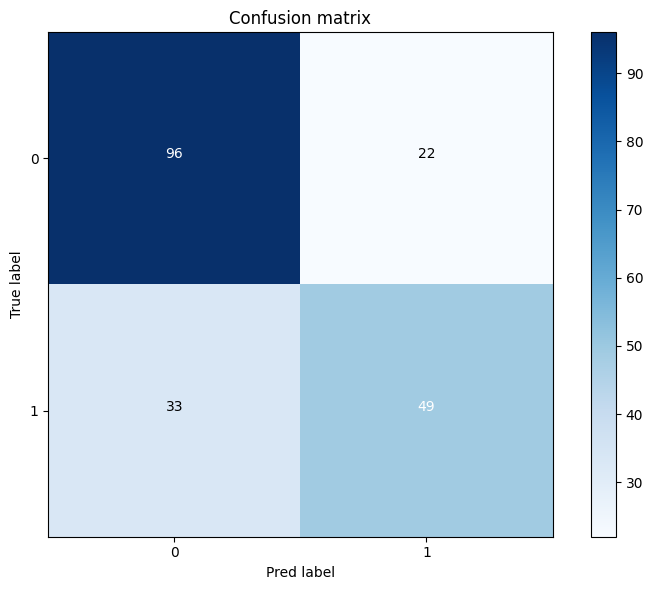

In [133]:
# Single Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
plot_confusion_matrix(Y_test, Y_pred, target_names=clf.classes_)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       118
           1       0.79      0.63      0.70        82

    accuracy                           0.78       200
   macro avg       0.78      0.76      0.76       200
weighted avg       0.78      0.78      0.78       200



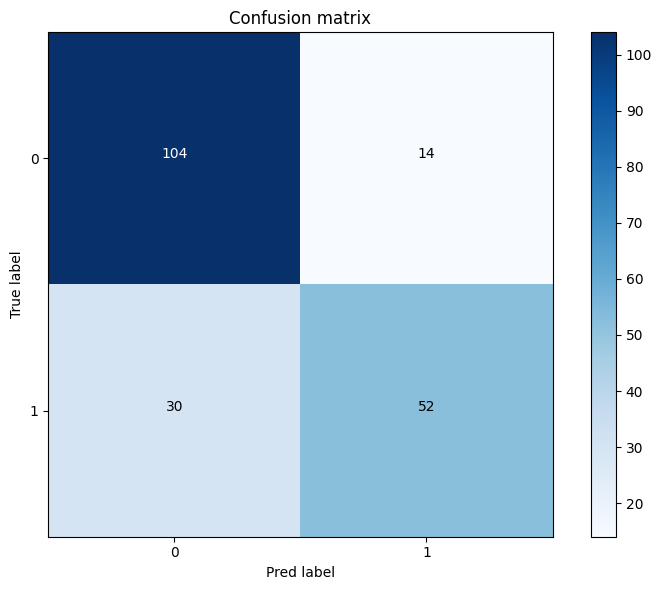

In [ ]:
# Decision Tree with Bagging
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
plot_confusion_matrix(Y_test, Y_pred, target_names=clf.classes_)

### 5.3. VotingClassifier

* 여러개의 모델을 같이 써서, soft voting 혹은 hard voting에 의해 최종 예측값이 결정됨.
![](https://miro.medium.com/v2/resize:fit:1400/1*2KMR70n4sqEkMsbyY63LBw.png)

* 안 쓰고 싶은 모델이 있으면 `set_params(name='drop')`으로 하면 됨
* Parameters:
  * n_jobs
  * weights: Voting할 때 estimator마다 부여하게 되는 weight

In [152]:
clf = VotingClassifier([
    ('lr', LogisticRegression(multi_class='multinomial', random_state=0)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
    ('gnb', GaussianNB()),
], voting='hard')

clf.get_params()

{'estimators': [('lr',
   LogisticRegression(multi_class='multinomial', random_state=0)),
  ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
  ('gnb', GaussianNB())],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'lr': LogisticRegression(multi_class='multinomial', random_state=0),
 'rf': RandomForestClassifier(n_estimators=50, random_state=0),
 'gnb': GaussianNB(),
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'multinomial',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 0,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': Non

In [154]:
clf.set_params(gnb='drop')
clf.get_params()

{'estimators': [('lr',
   LogisticRegression(multi_class='multinomial', random_state=0)),
  ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
  ('gnb', 'drop')],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'hard',
 'weights': None,
 'lr': LogisticRegression(multi_class='multinomial', random_state=0),
 'rf': RandomForestClassifier(n_estimators=50, random_state=0),
 'gnb': 'drop',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'multinomial',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 0,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       118
           1       0.95      0.67      0.79        82

    accuracy                           0.85       200
   macro avg       0.88      0.82      0.84       200
weighted avg       0.87      0.85      0.84       200



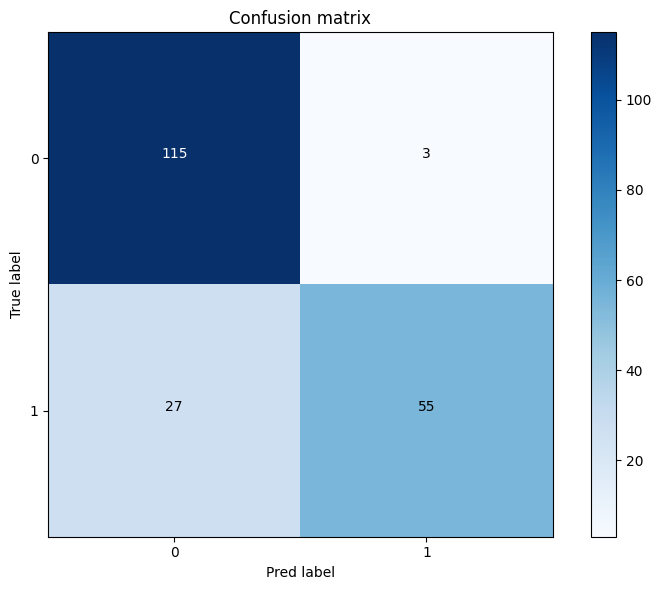

In [155]:
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
plot_confusion_matrix(Y_test, Y_pred, target_names=clf.classes_)

### 5.4. Exercise: VotingRegressor

Write your code in the cells below.<br/>

  1. Load *Hitters* Dataset (regression)
  2. Preprocess the Data:
    - Make sure non-numerical values become numerical
  3. Prepare X, Y
  4. Split train / test data
  5. Use VotingRegressor with GridSearchCV to finetune some hyperparameters (of your choice)

In [168]:
df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna() # missing values가 있는 row는 다 지우기
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], drop_first=True)

X = df.drop(columns=['Salary'])
Y = df['Salary']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(210, 19) (53, 19) (210,) (53,)


0.640456180280718

In [170]:
# Create base regressors
regressor1 = RandomForestRegressor(random_state=1)
regressor2 = GradientBoostingRegressor(random_state=1)

# Create VotingRegressor
voting_regressor = VotingRegressor(
    estimators=[('rf', regressor1), ('gb', regressor2)]
)

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [10, 50],
    'rf__max_depth': [3, 10],
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.01, 0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=voting_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('rf',
                                                    RandomForestRegressor(random_state=1)),
                                                   ('gb',
                                                    GradientBoostingRegressor(random_state=1))]),
             param_grid={'gb__learning_rate': [0.01, 0.1],
                         'gb__n_estimators': [50, 100],
                         'rf__max_depth': [3, 10],
                         'rf__n_estimators': [10, 50]},
             scoring='neg_mean_squared_error')

In [172]:
print("Best parameter combination is: ", grid_search.best_params_)

Best parameter combination is:  {'gb__learning_rate': 0.1, 'gb__n_estimators': 50, 'rf__max_depth': 3, 'rf__n_estimators': 10}


# Supplementary:
- decision trees 다른 방법으로 그리는 방법
- ticks가 가운데 오게 하기, histogram box outline 그리기 (1.1)

## Other ways to plot trees

In [183]:
import graphviz
from sklearn import tree


df = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna() # missing values가 있는 row는 다 지우기
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], drop_first=True)

X = df.drop(columns=['Salary'])
Y = df['Salary']

regr = DecisionTreeRegressor(
    max_leaf_nodes=3,
    criterion='squared_error'
    )
regr.fit(X, Y)

DecisionTreeRegressor(max_leaf_nodes=3)

In [184]:
# Textual representation
text_model = tree.export_text(regr)
print(text_model)

|--- feature_8 <= 450.00
|   |--- value: [227.85]
|--- feature_8 >  450.00
|   |--- feature_5 <= 61.00
|   |   |--- value: [649.62]
|   |--- feature_5 >  61.00
|   |   |--- value: [1112.59]



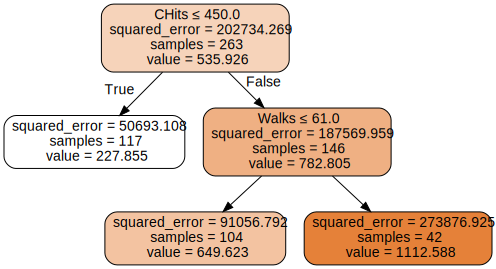

In [189]:
# Graphviz
dot_data = tree.export_graphviz(regr,
                                feature_names=X.columns,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Useful links
1. https://scikit-learn.org/stable/modules/ensemble.html
2. https://scikit-learn.org/stable/modules/tree.html
3. https://www.youtube.com/playlist?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF
4. https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
5. https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py